# 1. Import relevant libraries

In [91]:
# General libraries
import operator
import warnings
warnings.filterwarnings('ignore')

# Import data manipulation libraries
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy import stats

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Import machine learning libraries
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Import CatBoost % XGBoost
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
import xgboost
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report

# Showing all the features in the head function
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 2. Import dataset

In [3]:
# Read the dataset and check for missing values, types of features etc.
raw_data = pd.read_csv("data.csv")
# raw_data.head()

In [4]:
# See the shape of the dataset - We have 50k rows and 25 features
raw_data.shape

(48976, 25)

In [5]:
# Let's see our features. Shall we?
raw_data.describe()

,age,hospitalization,num_callouts,num_diagnoses,num_procedures,num_cptevents,num_inputevents,num_labevents,num_microbiologyevents,num_noteevents,num_outputevents,num_procedureevents,num_transfers,num_chartevents,expired,patient_id
count,48976.000000,48976.000000,48976.000000,48976.000000,48976.000000,48976.000000,48976.000000,48976.000000,48976.000000,48976.000000,48976.000000,48976.000000,48976.000000,48976.000000,48976.000000,48976.000000
mean,52.880574,10.085454,0.486606,2.677291,0.719005,1.046329,30.138027,46.397052,1.179823,6.293144,7.094189,0.690277,1.070524,527.014599,0.098783,24487.500000
std,26.072615,12.445730,0.856137,8.188330,3.674547,2.002183,63.043404,76.221281,4.477031,102.092164,7.457007,2.144865,3.159967,653.364421,0.298374,14138.297729
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,43.000000,3.710000,0.000000,1.000000,0.000000,0.000000,5.000000,27.000000,0.000000,0.000000,2.000000,0.000000,0.000000,207.000000,0.000000,12243.750000
50%,59.000000,6.420000,0.000000,1.000000,0.000000,1.000000,14.000000,39.000000,1.000000,0.000000,5.000000,0.000000,1.000000,418.000000,0.000000,24487.500000
75%,73.000000,11.750000,1.000000,2.000000,1.000000,2.000000,34.000000,51.000000,1.000000,1.000000,10.000000,1.000000,1.000000,699.000000,0.000000,36731.250000
max,89.000000,294.630000,20.000000,350.000000,275.000000,225.000000,6825.000000,5175.000000,375.000000,5625.000000,375.000000,100.000000,100.000000,49325.000000,1.000000,48975.000000


In [6]:
# Let's see the type of each feature - We have 16 numerical and 9 categorical features
# raw_data.dtypes
print(raw_data.dtypes.astype(str).value_counts())

int64      15
object      9
float64     1
dtype: int64


In [7]:
# See if there are missing values
# raw_data.info() or the one below is better
raw_data.isna().sum()[raw_data.isna().sum() != 0].sort_values()

admission_diagnosis      21
religion                378
ethnicity               701
insurance               830
admission_procedure    1492
admission_origin       3576
marital_status         8649
dtype: int64

# 3. Exploratory Data Analysis (EDA)

In [8]:
# Function that you can find missing values in a chart, sorted
def missing(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percentage'])
    plt.subplots(figsize=(15,5))
    missing_data["Total"].plot.bar()
    plt.title("NUMBER OF MISSING VALUES")
    plt.legend()
    plt.show()
    return missing_data

In [14]:
# missing(raw_data)

In [9]:
# Function that you can find the outliers, using the μ +- 3σ statistical method.
def outliers(data):
    numerics = ['int64','float64']
    num_df = data.select_dtypes(include=numerics).drop(["expired","patient_id"],axis=1)
    my_dict = dict()
    for col in num_df:
        i = 0
        m = num_df[col].mean()
        s = num_df[col].std()
        for row in num_df[col]:
            if row > (m + 3*s) or row < (m - 3*s):
                i+=1
        my_dict.update({col:i})
    plt.subplots(figsize=(35,5))
    plt.bar(my_dict.keys(),my_dict.values())
    plt.show()
    return my_dict

In [16]:
# outliers(raw_data)

In [10]:
# Functions for data visualization
def histogramms(data):
    data = data.drop(["patient_id"],axis=1)
    data.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

def descriptives_of_numerics(data):
    plt.figure(figsize=(20, 10))
    sns.distplot(data, color='g', bins=100, hist_kws={'alpha': 0.4}, fit=norm);
    fig = plt.figure()
    res = stats.probplot(data, plot=plt)
    print("Skewness: %f" % data.skew())
    print("Kurtosis: %f" % data.kurt())
    return data.describe()
    
def descriptives_of_categoricals(data):
    categoricals = data.select_dtypes(include=['O'])
    sns.boxplot(categoricals)
    plt.show()
    return categoricals.describe()

def fun_correl_coeff(data):
    columns_reordered = ['patient_id', 'gender', 'age', 'admission_type',
       'admission_origin', 'admission_diagnosis', 'admission_procedure', 'insurance', 'religion',
       'marital_status', 'ethnicity', 'expired','num_callouts', 'num_diagnoses',
       'num_procedures', 'num_cptevents', 'num_inputevents', 'num_labevents', 'num_microbiologyevents',
       'num_noteevents', 'num_outputevents', 'num_procedureevents',
       'num_transfers', 'num_chartevents', 'hospitalization']
    data_without_id = data[columns_reordered].drop(['patient_id'], axis = 1)
    data_num = data_without_id.select_dtypes(include = ['float64', 'int64']).drop(['expired'], axis = 1)
    individual_features_df = []
    for i in range(len(data_num.columns) - 1):
        tmpDf = data_num[[data_num.columns[i], 'hospitalization']]
        tmpDf = tmpDf[tmpDf[data_num.columns[i]] != 0]
        individual_features_df.append(tmpDf)
    all_correlations = {feature.columns[0]: feature.corr()['hospitalization'][0] for feature in individual_features_df}
    all_correlations = sorted(all_correlations.items(), key=operator.itemgetter(1))
    for (key, value) in all_correlations:
        print("{:>15}: {:>15}".format(key, value))
    
def fun_heatmap_corr(data, k):
    corrmat = data.corr()
    f, ax = plt.subplots(figsize=(20, 20))
    cols = corrmat.nlargest(k, 'hospitalization')['hospitalization'].index
    cm = np.corrcoef(data[cols].values.T)
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, cmap="YlGnBu", cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
    plt.show()

def fun_heatmap_corr_1(data):
    data_num = data.select_dtypes(include = ['float64', 'int64']).drop(['expired'], axis = 1)
    corr = data_num.drop('hospitalization', axis=1).corr() # We already examined hospitalization correlations
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr[(corr >= 0.4) | (corr <= -0.4)], 
                cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
                annot=True, annot_kws={"size": 8}, square=True);

## Create a chekpoint 

In [17]:
data1 = raw_data.copy()

# Re order the columns, so our target will be in the end (the last value)
columns_reordered = ['patient_id', 'gender', 'age', 'admission_type',
       'admission_origin','insurance', 'admission_diagnosis','admission_procedure', 'religion',
       'marital_status', 'ethnicity', 'expired','num_callouts', 'num_diagnoses',
       'num_procedures', 'num_cptevents', 'num_inputevents', 'num_labevents', 'num_microbiologyevents',
       'num_noteevents', 'num_outputevents', 'num_procedureevents',
       'num_transfers', 'num_chartevents', 'hospitalization']
data1 = data1[columns_reordered]

In [18]:
# Showing the categorical values
data_cat = data1.select_dtypes(include = ['O'])
data_cat.head(7)

,gender,admission_type,admission_origin,insurance,admission_diagnosis,admission_procedure,religion,marital_status,ethnicity
0,M,EMERGENCY,CLINIC REFERRAL,Medicare,PNEUMONIA,Closed bronchial biopsy,NOT SPECIFIED,DIVORCED,WHITE
1,M,EMERGENCY,EMERGENCY ROOM ADMISSION,Government,SEIZURE,Cont inv mec ven <96 hrs,NOT SPECIFIED,SINGLE,PATIENT DECLINED TO ANSWER
2,M,EMERGENCY,ER ADMISSION,Government,SCALP LACERATION;RESPIRATORY FAILURE,Cont inv mec ven 96+ hrs,UNOBTAINABLE,DIVORCED,BLACK/AFRICAN AMERICAN
3,F,URGENT,TRANSFER FROM HOSPITAL,Private,CARDIAC DZ.,Implt/repl carddefib tot,OTHER,MARRIED,UNKNOWN/NOT SPECIFIED
4,F,ELECTIVE,NaN,Medicare,ABDOMINAL LAXITY/SDA,Uterine les destruct NEC,NOT SPECIFIED,SINGLE,WHITE
5,F,EMERGENCY,TRANSFER FROM HOSP.,Private,RESPIRATORY FAILURE,Cont inv mec ven <96 hrs,NOT SPECIFIED,MARRIED,WHITE
6,F,EMERGENCY,CLINIC REFERRAL,Medicare,ABDOMINAL PAIN,Venous cath NEC,PROTESTANT QUAKER,SINGLE,BLACK/AFRICAN AMERICAN


In [55]:
# Function that taking care all the Data cleansing of the Dataset
def cleaning(data):
    
    # Dropping all the NaN values.
    data = data.dropna() 

    # Outliers
    data = data[(data["num_callouts"] < (data["num_callouts"].mean() + 3* data["num_callouts"].std())) &
               (data["num_callouts"] > (data["num_callouts"].mean() - 3* data["num_callouts"].std()))]
    data = data[(data["num_diagnoses"] < (data["num_diagnoses"].mean() + 3* data["num_diagnoses"].std())) &
               (data["num_diagnoses"] > (data["num_diagnoses"].mean() - 3* data["num_diagnoses"].std()))]
    data = data[(data["num_procedures"] < (data["num_procedures"].mean() + 3* data["num_procedures"].std())) &
               (data["num_procedures"] > (data["num_procedures"].mean() - 3* data["num_procedures"].std()))]
    data = data[(data["num_cptevents"] < (data["num_cptevents"].mean() + 3* data["num_cptevents"].std())) &
               (data["num_cptevents"] > (data["num_cptevents"].mean() - 3* data["num_cptevents"].std()))]
    data = data[(data["num_inputevents"] < (data["num_inputevents"].mean() + 3* data["num_inputevents"].std())) &
               (data["num_inputevents"] > (data["num_inputevents"].mean() - 3* data["num_inputevents"].std()))]
    data = data[(data["num_labevents"] < (data["num_labevents"].mean() + 3* data["num_labevents"].std())) &
               (data["num_labevents"] > (data["num_labevents"].mean() - 3* data["num_labevents"].std()))]
    data = data[(data["num_microbiologyevents"] < (data["num_microbiologyevents"].mean() + 3* data["num_microbiologyevents"].std())) &
               (data["num_microbiologyevents"] > (data["num_microbiologyevents"].mean() - 3* data["num_microbiologyevents"].std()))]
    data = data[(data["num_noteevents"] < (data["num_noteevents"].mean() + 3* data["num_noteevents"].std())) &
               (data["num_noteevents"] > (data["num_noteevents"].mean() - 3* data["num_noteevents"].std()))]
    data = data[(data["num_outputevents"] < (data["num_outputevents"].mean() + 3* data["num_outputevents"].std())) &
               (data["num_outputevents"] > (data["num_outputevents"].mean() - 3* data["num_outputevents"].std()))]
    data = data[(data["num_procedureevents"] < (data["num_procedureevents"].mean() + 3* data["num_procedureevents"].std())) &
               (data["num_procedureevents"] > (data["num_procedureevents"].mean() - 3* data["num_procedureevents"].std()))]
    data = data[(data["num_transfers"] < (data["num_transfers"].mean() + 3* data["num_transfers"].std())) &
               (data["num_transfers"] > (data["num_transfers"].mean() - 3* data["num_transfers"].std()))]
    data = data[(data["num_chartevents"] < (data["num_chartevents"].mean() + 3* data["num_chartevents"].std())) &
               (data["num_chartevents"] > (data["num_chartevents"].mean() - 3* data["num_chartevents"].std()))]
    
    # Wrong values / mapping
    data = data[data.admission_origin != '?']

    data = data[data.admission_origin != 'NOT AVAIL.']

    data = data[data.admission_origin != 'NOT AVAILABLE']

    data['admission_origin'] = data['admission_origin'].str.strip()

    data['admission_origin'] = data['admission_origin'].replace(['ADMITTED FRIM EMERGENCY','ADMITTED FROM EMERGENCY','EMERG. ROOM ADMISSION',
                                   'EMERGENCY ROOM ADMIT','ER ADMISSION','ER ADMIT','ER ADMIT','ER ADMISSION'], 'EMERGENCY ROOM ADMISSION')

    data['admission_origin'] = data['admission_origin'].replace(['CINIC REFERRAL','CLINIC','CLINIC REFERAL',
                                   'FROM CLINIC','REFERRAL','CLINIC  REFERRAL',
                                                                        "HMO REFERAL","HMO REFERRAL"], 'CLINIC REFERRAL')

    data['admission_origin'] = data['admission_origin'].replace(['PHYS REFERRA','PHYSICAL   REFERRAL','PHYSICAL  REFERRAL',
                                                            'PHYS REFERRAL'], 'PHYSICAL REFERRAL')

    data['admission_origin'] = data['admission_origin'].replace(["HOSP. TRAN.", 'TRANFSER FROM HOSPITAL','TFH'
                                                            ,'TRANS FRM HPL', 'TRANSFER FROM HOSP.','TRANSFER FROM HOSPITAL'
            ,'TRANSFER FROM SAME HOSPITAL',"TRANSFER FROM SKILLED NURSE", 'TRANFSER FROM SAME HOSP.', "TRANS FRM SKL NURSE", 'INTERNAL TRANSFER', 'TRANSFER FROM OTHER HEALTH CENTER',
                                                                        'TRANSFER FROM OHTER HEALTH CENTER', 'TRNS FR HEALTH CNTR','TRANSFER FROM OTHER  HEALTH CENTER'], 'HOSPITAL TRANSFER')
    
    data['admission_origin'] = data['admission_origin'].map({"EMERGENCY ROOM ADMISSION": 0 , "PHYSICAL REFERRAL":1,
                                                            'CLINIC REFERRAL':2,'HOSPITAL TRANSFER':3})

    data['gender'] = data['gender'].map({'M' : 0,"F" : 1})
    
    data = data[(data.insurance != '?') & (data.insurance != ' ')]
    
    data['insurance'] = data['insurance'].map({'Medicare' : 0,"Private" : 1, 'Medicaid': 2, 'Government': 3, 'Self Pay': 4 })
    
    data['admission_type'] = data['admission_type'].map({'EMERGENCY' : 0, "NEWBORN" : 1, 'ELECTIVE': 2, 'URGENT': 3 })
    
    # Reset index
    data = data.reset_index()
    data = data.drop(['index'],axis=1)
    
    # Binning age
    for i in range(len(data['age'])):
        if data['age'][i] < 1:
            data['age'][i] = 1
        elif data['age'][i] >= 1 and data['age'][i] < 35:
            data['age'][i] = 2
        elif data['age'][i] >= 35 and data['age'][i] < 65:
            data['age'][i] = 3
        else:
            data['age'][i] = 4
    
    # Hospitalization simple mapping
    for i in range(len(data['hospitalization'])):
        if data['hospitalization'][i] < 1:
            data['hospitalization'][i] = "Day"
        elif data['hospitalization'][i] >= 1 and data['hospitalization'][i] < 7:
            data['hospitalization'][i] = "Week"
        elif data['hospitalization'][i] >= 7 and data['hospitalization'][i] < 14:
            data['hospitalization'][i] = "TwoWeeks"
        elif data['hospitalization'][i] >= 15 and data['hospitalization'][i] < 30:
            data['hospitalization'][i] = "Month"
        else:
            data['hospitalization'][i] = "More"
        
    return data

In [56]:
# Data without outliers, missing values
cleaned_data = cleaning(raw_data)

In [57]:
cleaned_data.head()

# cleaned_data.isna().sum()

,gender,age,hospitalization,admission_type,admission_origin,admission_diagnosis,insurance,religion,marital_status,ethnicity,num_callouts,num_diagnoses,num_procedures,admission_procedure,num_cptevents,num_inputevents,num_labevents,num_microbiologyevents,num_noteevents,num_outputevents,num_procedureevents,num_transfers,num_chartevents,expired,patient_id
0,0,4,Week,0,2,PNEUMONIA,0,NOT SPECIFIED,DIVORCED,WHITE,1,2,0,Closed bronchial biopsy,1,7,37,3,0,2,0,1,356,0,0
1,0,2,Week,0,0,SEIZURE,3,NOT SPECIFIED,SINGLE,PATIENT DECLINED TO ANSWER,1,0,1,Cont inv mec ven <96 hrs,2,51,44,2,1,11,0,1,763,0,1
2,0,3,Month,0,0,SCALP LACERATION;RESPIRATORY FAILURE,3,UNOBTAINABLE,DIVORCED,BLACK/AFRICAN AMERICAN,0,1,1,Cont inv mec ven 96+ hrs,1,63,48,3,0,16,0,0,1102,0,2
3,1,3,TwoWeeks,3,3,CARDIAC DZ.,1,OTHER,MARRIED,UNKNOWN/NOT SPECIFIED,0,1,0,Implt/repl carddefib tot,1,3,22,1,0,1,0,0,38,0,3
4,1,3,TwoWeeks,0,3,RESPIRATORY FAILURE,1,NOT SPECIFIED,MARRIED,WHITE,1,3,0,Cont inv mec ven <96 hrs,2,4,32,0,0,3,0,0,276,0,5


In [59]:
# Imbalanced data, because most of the values are placed in the Week category and then TwoWeeks
cleaned_data["hospitalization"].value_counts()

Week        13668
TwoWeeks     9713
Month        4237
More         1969
Day            79
Name: hospitalization, dtype: int64

# 3.1 Machine Learning - Modeling part

In [60]:
x_num = cleaned_data[["num_callouts","num_diagnoses","num_procedures","num_transfers","num_chartevents"]]
x_cat = cleaned_data[["gender","admission_type","admission_origin","insurance","expired","age"]]

Feature 0: 1143.093501
Feature 1: 1833.664289
Feature 2: 335.167554
Feature 3: 4630.980318
Feature 4: 43.298706


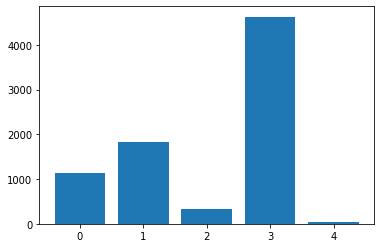

In [61]:
# Select features according to the k highest scores. [ANOVA F-value] 
# See the feature importance

def select_num_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=f_classif, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

# Split the dataset to train, test. [70% - 30%]
X_train, X_test, y_train, y_test = train_test_split(x_num, cleaned_data["hospitalization"], test_size=0.30, random_state=1)
X_train_fs, X_test_fs, fs = select_num_features(X_train, y_train, X_test)

for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

Feature 0: 1.057394
Feature 1: 109.578381
Feature 2: 53.360731
Feature 3: 109.593185
Feature 4: 485.442523
Feature 5: 22.323086


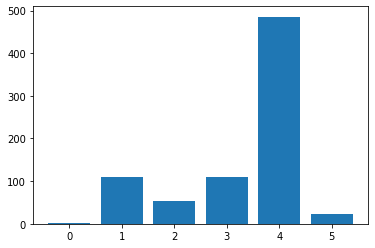

In [63]:
# Chi-squared stats of non-negative features for classification tasks.

def select_cat_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func = chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

X_train, X_test, y_train, y_test = train_test_split(x_cat, cleaned_data["hospitalization"], test_size=0.33, random_state=1)
X_train_fs, X_test_fs, fs = select_cat_features(X_train, y_train, X_test)
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

## Cat Boost model

In [67]:
features = cleaned_data.drop(['hospitalization'], axis=1)
target = cleaned_data["hospitalization"]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3)

In [68]:
X_train.shape

(20766, 24)

### Declare feature vector and target variable

In [69]:
X = X_train
y = y_train

In [70]:
cat_features = X.select_dtypes(include= ['O'])
cat_features.head()

,admission_diagnosis,religion,marital_status,ethnicity,admission_procedure
4585,CEREBRAL INFARCT,UNOBTAINABLE,DIVORCED,UNKNOWN/NOT SPECIFIED,Insert endotracheal tube
2742,OPEN WOUND CHEST WALL/SDA,NOT SPECIFIED,MARRIED,WHITE,Clos thoracic fistul NEC
4617,CORONARY ARTERY DISEASE,CATHOLIC,MARRIED,WHITE,Aortocor bypas-2 cor art
1473,DYSPNEA,CATHOLIC,MARRIED,WHITE,Venous cath NEC
16432,S/P MI\CATH,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,na


In [72]:
X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.3, random_state=0)

In [73]:
clf = CatBoostClassifier(
    iterations=5, 
    learning_rate=0.1, 
    #loss_function='CrossEntropy'
)


clf.fit(X_train1, y_train1, 
        cat_features=cat_features, 
        eval_set=(X_val, y_val), 
        verbose=False
)

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 5, 'learning_rate': 0.1}


In [74]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier(
    iterations=10,
#     verbose=5,
)

clf.fit(
    X_train1, y_train1,
    cat_features=cat_features,
    eval_set=(X_val, y_val),
)

Learning rate set to 0.5
0:	learn: 0.9977492	test: 1.0001706	best: 1.0001706 (0)	total: 56.5ms	remaining: 508ms
1:	learn: 0.8793445	test: 0.8825057	best: 0.8825057 (1)	total: 101ms	remaining: 403ms
2:	learn: 0.7942799	test: 0.8016323	best: 0.8016323 (2)	total: 188ms	remaining: 438ms
3:	learn: 0.7532490	test: 0.7607403	best: 0.7607403 (3)	total: 287ms	remaining: 430ms
4:	learn: 0.7284915	test: 0.7371142	best: 0.7371142 (4)	total: 374ms	remaining: 374ms
5:	learn: 0.7023832	test: 0.7117409	best: 0.7117409 (5)	total: 461ms	remaining: 307ms
6:	learn: 0.6922961	test: 0.7021100	best: 0.7021100 (6)	total: 558ms	remaining: 239ms
7:	learn: 0.6810729	test: 0.6910727	best: 0.6910727 (7)	total: 643ms	remaining: 161ms
8:	learn: 0.6713691	test: 0.6827635	best: 0.6827635 (8)	total: 727ms	remaining: 80.8ms
9:	learn: 0.6672269	test: 0.6809884	best: 0.6809884 (9)	total: 820ms	remaining: 0us

bestTest = 0.6809883661
bestIteration = 9



In [75]:
print(clf.predict_proba(data=X_val))

[[0.00241673 0.00772828 0.00569066 0.20263786 0.78152646]
 [0.0022387  0.02113358 0.01049184 0.54392938 0.4222065 ]
 [0.00281794 0.23648017 0.07184184 0.61339053 0.07546952]
 ...
 [0.00124875 0.00421609 0.00327506 0.05606428 0.93519582]
 [0.00376418 0.3395655  0.13174546 0.45194875 0.07297611]
 [0.00213924 0.57162154 0.19638245 0.21568545 0.01417132]]


## XGBoost model

In [88]:
features = cleaned_data.drop(["hospitalization", "admission_diagnosis", "religion", "marital_status", "ethnicity", "admission_procedure"],axis=1)
target = cleaned_data["hospitalization"]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3)

In [89]:
model = XGBClassifier(booster='gbtree', objective = 'multi:softprob')
params = {'max_depth': [3,4,5,6], 'learning_rate': [0.01, 0.1, 0.2],'colsample_bytree': [0.6, 0.8, 1.0]}
random_search = RandomizedSearchCV(model, param_distributions=params, cv=5)
random_search.fit(X_train, y_train)

[23:33:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:33:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:33:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:33:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[23:35:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:35:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:36:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:36:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           objective='multi:softprob',
                             

In [90]:
preds = random_search.predict(X_test)

In [92]:
report = classification_report(y_test, preds)
conf_matrix = confusion_matrix(y_test, preds)

In [93]:
# Confusion matrix with precision, recall & f1-score.
print(preds)
print(report)
print(conf_matrix)

['Week' 'TwoWeeks' 'TwoWeeks' ... 'TwoWeeks' 'Month' 'TwoWeeks']
              precision    recall  f1-score   support

         Day       0.80      0.80      0.80        15
       Month       0.54      0.52      0.53      1259
        More       0.59      0.24      0.34       586
    TwoWeeks       0.61      0.68      0.64      2942
        Week       0.84      0.85      0.85      4098

    accuracy                           0.71      8900
   macro avg       0.68      0.62      0.63      8900
weighted avg       0.71      0.71      0.70      8900

[[  12    0    0    0    3]
 [   1  651   83  514   10]
 [   0  278  139  167    2]
 [   0  267   14 2002  659]
 [   2    9    1  583 3503]]


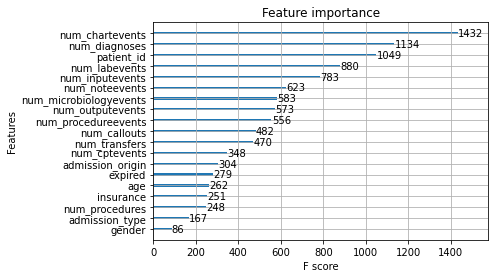

In [94]:
# Feature importance
best_model = random_search.best_estimator_
xgboost.plot_importance(best_model)
plt.show()

In [95]:
# Best parameters of the model
random_search.best_params_

{'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}